# multiphase/interFoam/laminar/mixerVessel2D


In [1]:
%matplotlib inline
import numpy as np
from vtk.util.numpy_support import vtk_to_numpy
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import vtk
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D


In [59]:
def plotPolar(nodes, a, vmin=0, vmax=0):
    color_map = plt.cm.get_cmap('seismic')
    ax = plt.subplot(111, projection='polar')
    print"Shapes: {} {} {}".format(nodes[:,0].shape, nodes[:,1].shape, a.shape)
    ax.plot(nodes[:,0], nodes[:,1], 
            color=a, 
            cmap = color_map)
    ax.set_rmax(2.0)
    ax.grid(True)

    ax.set_title("A line plot on a polar axis", va='bottom')
    plt.show()

In [112]:
import os
files = os.listdir("out/VTK/")
for f in files[:12]:
    print(f)

back
front
mixerVessel2D_0.vtk
mixerVessel2D_138.vtk
mixerVessel2D_175.vtk
mixerVessel2D_212.vtk
mixerVessel2D_246.vtk
mixerVessel2D_277.vtk
mixerVessel2D_305.vtk
mixerVessel2D_331.vtk
mixerVessel2D_355.vtk
mixerVessel2D_377.vtk


In [104]:
def plot3D(nodes, a, vmin=0, vmax=0):
    print"Shapes: {} {} {}".format(nodes[:,0].shape, nodes[:,1].shape, a.shape)
    color_map = plt.cm.get_cmap('plasma')
    fig = plt.figure(figsize=(14,10))
    ax = fig.add_subplot(111, projection='3d')
    if vmax==0 and vmin==0:
        vmin = np.amin(a)
        vmax = np.amax(a)
    splt = ax.scatter(nodes[:,0],nodes[:,1],nodes[:,2],s=60,
                   c = a,
                   cmap = color_map,
                   vmin = vmin,
                   vmax = vmax,
                   marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    fig.colorbar(splt, shrink=0.5)
    plt.show()

In [110]:
def getData(filename):
    # load a vtk file as input
    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(filename)
    reader.Update()
    vtk_arrays= reader.GetOutput().GetPointData()
    #print vtk_nodes
    print vtk_arrays
    return vtk_arrays

def getNodes(filename):
    # load a vtk file as input
    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(filename)
    reader.Update()
    print reader.GetOutput().GetPoints()
    # Get the coordinates of nodes in the mesh
    nodes_vtk_array= reader.GetOutput().GetPoints().GetData()  
    nodes = vtk_to_numpy(nodes_vtk_array)
    return nodes

In [113]:
filename = "out/VTK/mixerVessel2D_54.vtk"
#nodes, p , U   = getData_pvm(filename)
vtk_data = getData(filename)
nodes = getNodes(filename)
print nodes
p = vtk_to_numpy(vtk_data.GetArray(0))
#print p
alpha = vtk_to_numpy(vtk_data.GetArray(1))
print alpha
p_rgh = vtk_to_numpy(vtk_data.GetArray(2))
U = vtk_to_numpy(vtk_data.GetArray(3))
a = alpha

vmin = np.nanmin(a)
vmax = np.nanmax(a)
print "{} - {}".format(vmin,vmax)
print a.shape



vtkPointData (0x368fb40)
  Debug: Off
  Modified Time: 14895
  Reference Count: 2
  Registered Events: (none)
  Number Of Arrays: 4
  Array 0 name = p
  Array 1 name = alpha.water
  Array 2 name = p_rgh
  Array 3 name = U
  Number Of Components: 6
  Number Of Tuples: 6528
  Copy Tuple Flags: ( 1 1 1 1 1 0 1 1 )
  Interpolate Flags: ( 1 1 1 1 1 0 0 1 )
  Pass Through Flags: ( 1 1 1 1 1 1 1 1 )
  Scalars: (none)
  Vectors: (none)
  Normals: (none)
  TCoords: (none)
  Tensors: (none)
  GlobalIds: (none)
  PedigreeIds: (none)
  EdgeFlag: (none)


vtkPoints (0x3135ca0)
  Debug: Off
  Modified Time: 15051
  Reference Count: 2
  Registered Events: (none)
  Data: 0x3135b20
  Data Array Name: Points
  Number Of Points: 6528
  Bounds: 
    Xmin,Xmax: (-2.76488e+38, 2.25412e+38)
    Ymin,Ymax: (-2.76488e+38, 2.25412e+38)
    Zmin,Zmax: (0, 2.0717e-32)


[[  2.07651488e-32   0.00000000e+00   0.00000000e+00]
 [  6.19232506e-02   6.38768400e+07   0.00000000e+00]
 [  3.58572197e-06   6.40683803e+11  

In [103]:
def extractFlatData(nodes, a, U):
    merged = np.empty([len(nodes),6])
    merged[:,0] = a
    merged[:,1:3] = U[:,:2]
    merged[:,3:] = nodes
    # Merged z0 and z1 arrays should be same because of 
    # the model symmetry along z-axis
    merged_z0 = merged[np.where(merged[:,5] == 0)]
    merged_z1 = merged[np.where(merged[:,5] != 0)]
    # Extract nodes, p and U arrays from z0 array
    a = merged_z0[:,0]
    U = merged_z0[:,1:3]
    nodes = merged_z0[:,3:5]
    return nodes, a, U

def plot2D(nodes, a, vmin, vmax):     
    # 2d plotting
    fig = plt.figure(figsize=(8,6))
    cmap = mpl.cm.seismic
    color_map = plt.cm.get_cmap('plasma')
    axes = plt.gca()
    #axes.set_xlim([-.1,2.1])
    #axes.set_ylim([-.01,0.11])
    #plt.axis('off')
    sc = plt.scatter(nodes[:,0],nodes[:,1],
                     s=320,
#                     color=cmap(a / a_max),
                     c = a,
                     cmap = color_map,
                     vmin = vmin,
                     vmax = vmax,
                     linewidth=0, 
                     marker="s")
    plt.colorbar(sc)
    fig.tight_layout()

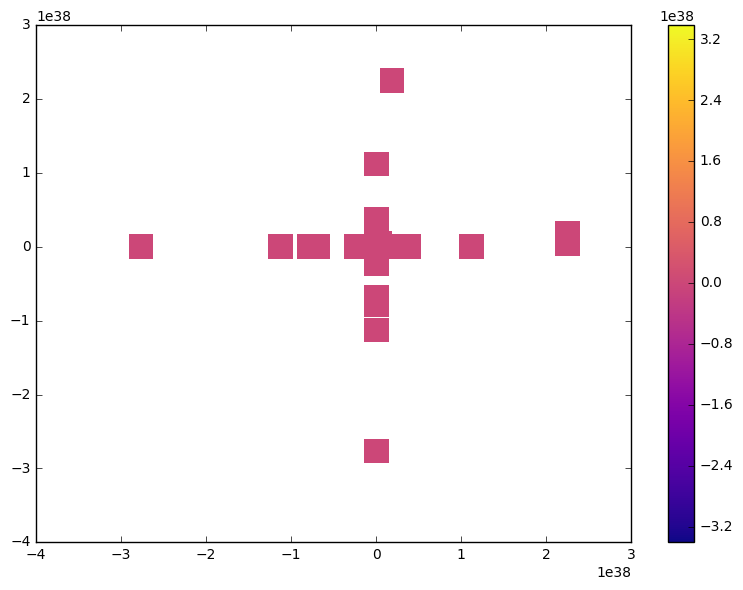

In [109]:
nodes_half, a_half, U_half = extractFlatData(nodes, a, U)
plot2D(nodes_half,a_half, vmin, vmax)

In [ ]:
R = nodes[:,0]
P = nodes[:,1]
X, Y = R*np.cos(P), R*np.sin(P)
C = np.stack((X,Y,nodes[:,2]), axis=-1)
plot3D(C, a, vmin, vmax)
plot3D(nodes, a, vmin, vmax)
#plotPolar(nodes, a, vmin, vmax)